In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

 Un experimentopuso en marcha 50 turbinas durante distintos intervalos de tiempo.
 Se registró la proporción de turbinas que desarrollaban fisuras durante cada prueba. Los datos están en el archivo turbines.csv

In [3]:
path = './turbines.csv'
df = pd.read_csv(path)
df.columns = ['Hours', 'Proportions of Fissures']
n = len(df)

In [4]:
df

,Hours,Proportions of Fissures
0,400,0.0000
1,1000,0.0755
2,1400,0.0606
3,1800,0.0959
4,2200,0.1667
5,2600,0.2308
6,3000,0.2143
7,3400,0.4615
8,3800,0.6471
9,4200,0.5250


a) Graficar la proporción de turbinas con fisuras vs la cantidad de horas de cada prueba. 
Justificar por qué un MLG binomial es una opción razonable para modelar la dependencia de 
la fracción de turbinas con fisuras respecto a la cantidad de horas. Proponer una función de vínculo.

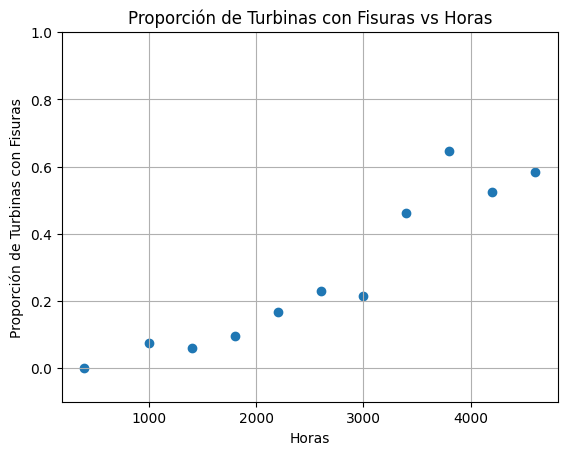

In [22]:
# Graficar la proporción de turbinas con fisuras vs la cantidad de horas de cada prueba. 

plt.scatter(df['Hours'], df['Proportions of Fissures'])
plt.xlabel('Horas')
plt.ylabel('Proporción de Turbinas con Fisuras')
plt.title('Proporción de Turbinas con Fisuras vs Horas')
plt.ylim(-0.1,1)
plt.grid()
plt.show()

Como la respuesta del problema viene dada en proporciones de máquinas con fisuras durante las pruebas, es decir, los valores de $Y$ están entre 0 y 1. Por lo tanto, la elección de un GLM Binomial es una opción razonable para modelar la dependencia de la fracción de tiburas con fisuras respecto a la cantidad de horas.

 $$ \Large \Rightarrow f(y;p,n) =  {n \choose ny} p^{ny}(1-p)^{n-ny} = {n \choose ny} e^{ \frac{y\ln(\frac{p}{1 - p}) - (-\ln(p))}{\frac {1}{n}}} $$

$$ a(y,n) =  {n \choose ny}  \\
$$ \phi = \frac{1}{n}  \\
$$ \theta = ln(\frac{p}{1-p})  \\
$$ \kappa(\theta) =  ln(1 - e^{\theta}) $$ \\

- Función de vínculo
$$ \boxed {\eta = ln(\frac{p}{1-p}) = \beta_{0} +\beta_{1}X} $$

La likelihood es $$ \Large \mathcal{L}(p) = \prod_{i=1}^n a(y) e^{\frac{y_i\ln(\frac{p}{1-p})- ( -\ln(1-p))}{\frac{1}{n}}} = \prod_{i=1}^n a(y) e^{n(y_i\ln(\frac{p}{1-p})+\ln(1-p))}  $$

donde $ \large p = p(\beta_0,\beta_1) = \frac{e^{\beta_0 + \beta_1x_i}}{1 + e^{\beta_0 + \beta_1x_i}}$. Entonces maximizar $\mathcal{L}(p)$ es lo mismo que minimizar $-\log(\mathcal{L}(p) $ y eso es lo que hago en el código.

In [9]:
def neg_log_likelihood_binomial(beta, X, Y):
    p = np.exp(np.dot(X, beta)) / ( 1 + np.exp(np.dot(X, beta))) #función de vínculo
    return -n * np.sum( Y * np.log(p /(1-p)) + np.log(1 - p) )

b) Ajustar este MLG binomial, es decir, encontrar estimaciones puntuales para los parámetros
 de regresión 𝛽 justificando cada paso

In [20]:
x = np.array(df['Hours'])
Y = np.array(df['Proportions of Fissures'])

X_intercept = np.column_stack((np.ones(x.shape[0]), x)) # Agregar la columna de unos para el intercepto

beta_hat = np.linalg.inv(X_intercept.T @ X_intercept) @ X_intercept.T @ Y


b0 =  -3.9110381422605007
b1 =  0.001011005475358363


C:\Users\joaquinMiguel\AppData\Local\Temp\ipykernel_17808\661507747.py:3: RuntimeWarning: divide by zero encountered in log
  return -n * np.sum( Y * np.log(p /(1-p)) + np.log(1 - p) )
d:\Joaco's Fold\Importante\ESTUDIO\UNSAM - LCD\WORKSPACE\inferencia_estadisitca\.venv_estadistica\Lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\joaquinMiguel\AppData\Local\Temp\ipykernel_17808\661507747.py:3: RuntimeWarning: divide by zero encountered in log
  return -n * np.sum( Y * np.log(p /(1-p)) + np.log(1 - p) )


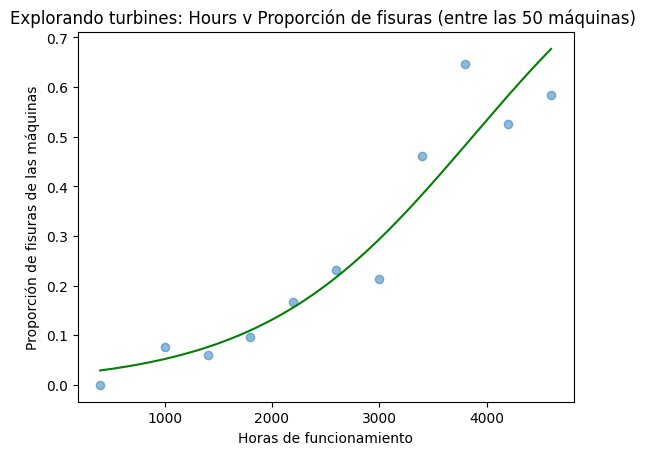

In [21]:
res_binomial = minimize(neg_log_likelihood_binomial, beta_hat, args=(X_intercept, Y))

b0 = res_binomial.x[0]
b1 = res_binomial.x[1]

print('b0 = ', b0)
print('b1 = ', b1)

x_range = np.linspace(x.min(), x.max(), 300)
binomial_fit = np.exp(b0 + b1 * x_range) / (1 + np.exp(b0 + b1 * x_range))

fig, ax = plt.subplots()
ax.scatter(x, Y, alpha=0.5)
ax.plot(x_range,binomial_fit,color='g')
ax.set_xlabel("Horas de funcionamiento")
ax.set_ylabel("Proporción de fisuras de las máquinas")
ax.set_title("Explorando turbines: Hours v Proporción de fisuras (entre las 50 máquinas) ")
plt.show()

c) Determinar el error estándar de cada parámetro de regresión justificando cada paso

Para esto necesito obtener la matriz de Fischer de la distribución:

$$I = \frac{1}{\phi}X^TWX \hspace{1cm}\text{ con }W = \text{diag}(\frac{1}{V(p_i)(d\eta_i/dp_i)^2}) $$

En nuestro caso:
$$\phi = \frac{1}{n} $$

$$ V(p) = p(1-p) $$

$$ \frac{d\eta}{dp} = \frac{d(\ln(\frac{p}{1 - p}))}{dp} = \frac{1}{p(1-p)}$$

por lo tanto $$I = nX^TWX \hspace{1cm}W = \text{diag}(p_i) = \text{diag}(p_i(1-p_i)) $$

con $p = p(\beta_0,\beta_1) = \frac{e^{\beta_0 + \beta_1x_i}}{1+e^{\beta_0 + \beta_1x_i}}$

Finalmente, la matriz de covarianza es $I^{-1}$ y su diagonal, las varianzas respectivas de $\beta_0$ y $\beta_1$:

In [23]:
phi = 1 / n
p = np.exp(X_intercept@res_binomial.x) / (1 + np.exp(X_intercept @ res_binomial.x))

W = np.diag( p * (1-p)  )

I = (1 / phi) * X_intercept.T @ W @ X_intercept

cov_matrix = np.linalg.inv(I)
cov_matrix

array([[ 5.59394407e-01, -1.57564696e-04],
       [-1.57564696e-04,  4.90629114e-08]])

In [ ]:
se_b0 = np.sqrt(cov_matrix[0,0])
se_b1 = np.sqrt(cov_matrix[1,1])
print("se(b0) =",se_b0)
print("se(b1) =",se_b1)